In [1]:
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D 
from keras.layers.convolutional import AveragePooling2D
from keras.layers.core import Activation, Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Permute,  Reshape
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras.layers import merge, Multiply

#K.set_image_dim_ordering("th")
SINGLE_ATTENTION_VECTOR = False


def attention_3d_block(inputs,timesteps):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    time_steps=timesteps
    print(input_dim)
    print(time_steps)
    a = Permute((2, 1))(inputs)
    #a = Reshape((input_dim, time_steps))(a) # this line is not useful. It's just to know which dimension is what.
    a = Dense(time_steps, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1))(a) #, name='dim_reduction'
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((2, 1))(a) #, name='attention_vec ' % (depth)
    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul= Multiply()([inputs, a_probs]) #name='attention_mul'
    return output_attention_mul


class LSTMATTBFnet:
    @staticmethod
    def build(timeSteps,variables,classes):
        inputNet = Input(shape=(timeSteps,variables)) #batch_shape=(20, 7, 5) 
        #lstm=Bidirectional(LSTM(100,recurrent_dropout=0.4,dropout=0.4),merge_mode='concat')(inputNet) #worse using stateful=True

        lstm=LSTM(100,recurrent_dropout=0.1,dropout=0.1,return_sequences=True)(inputNet) #worse using stateful=True 
        attention_mul = attention_3d_block(lstm,timeSteps)
        attention_mul = Flatten()(attention_mul)
        # a softmax classifier
        classificationLayer=Dense(classes,activation='softmax')(attention_mul)
        
        model=Model(inputNet,classificationLayer)
        return model


In [5]:
# load data
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


def non_shuffling_train_test_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test

# load all data
dfin = pd.read_csv('windows-size72-step12.csv',header=None)  #inputs 72 lines per sample
dfout = pd.read_csv('out-class-size72-step12.csv',header=None)  #output classes 

total_inputs,total_output = dfin.values.astype(np.float32),dfout.values.astype(np.int32)

# normalize
scaler = MinMaxScaler(feature_range=(0, 1))
total_inputs = scaler.fit_transform(total_inputs)

# every 72 lines is one input sample
total_inputs = np.reshape(total_inputs, (-1,72,8))
print("############# total shapes #############")
print(total_inputs.shape)
print(total_output.size)

train_inputs, test_inputs, train_output, test_output = non_shuffling_train_test_split(total_inputs, total_output, test_size=0.2)
#train_inputs, test_inputs, train_output, test_output = train_test_split(total_inputs, total_output, test_size=0.20, random_state=42)
print("############# train shapes #############")
print(train_inputs.shape)
print(train_output.shape)

print("############# test shapes #############")
print(test_inputs.shape)
print(test_output.shape)



############# total shapes #############
(2876, 72, 8)
2876
############# train shapes #############
(2301, 72, 8)
(2301, 1)
############# test shapes #############
(575, 72, 8)
(575, 1)


In [6]:

IMG_ROWS, IMG_COLS = 72, 8 # input image dimensions
NB_CLASSES = 5  # number of outputs = number of classes

X_train = train_inputs
y_train = np_utils.to_categorical(train_output, NB_CLASSES)
X_test = test_inputs
y_test = np_utils.to_categorical(test_output, NB_CLASSES)
print(y_test.shape)

OPTIMIZER = Adam()

model = LSTMATTBFnet.build(timeSteps=IMG_ROWS,variables=IMG_COLS,classes=NB_CLASSES)
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
	metrics=["accuracy"])

model.summary()


(575, 5)
100
72
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 72, 8)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 72, 100)      43600       input_1[0][0]                    
__________________________________________________________________________________________________
permute (Permute)               (None, 100, 72)      0           lstm[0][0]                       
__________________________________________________________________________________________________
dense (Dense)                   (None, 100, 72)      5256        permute[0][0]                    
_______________________________________________________________________

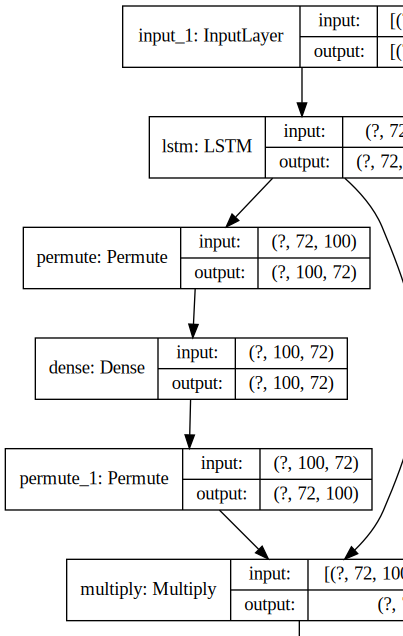

In [7]:
from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
modelSVG=SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG)

In [8]:
NB_EPOCH = 100
BATCH_SIZE = 64
VERBOSE = 1

#tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
#esCallBack = EarlyStopping(monitor='val_acc', min_delta=0, patience=12, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)
best_checkpoint = ModelCheckpoint('LSTM-ATTENTION-BF-polution.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
		batch_size=BATCH_SIZE, epochs=NB_EPOCH, 
		verbose=1, # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
		validation_data=(X_test,y_test),
		#validation_split=VALIDATION_SPLIT,
		callbacks=[reduce_lr,best_checkpoint])

Epoch 1/100
36/36 [==============================] - ETA: 0s - loss: 1.5901 - accuracy: 0.2395
Epoch 00001: val_accuracy improved from -inf to 0.22609, saving model to LSTM-ATTENTION-BF-polution.h5
36/36 [==============================] - 6s 174ms/step - loss: 1.5901 - accuracy: 0.2395 - val_loss: 1.5804 - val_accuracy: 0.2261
Epoch 2/100
36/36 [==============================] - ETA: 0s - loss: 1.4957 - accuracy: 0.3451
Epoch 00002: val_accuracy improved from 0.22609 to 0.25043, saving model to LSTM-ATTENTION-BF-polution.h5
36/36 [==============================] - 6s 163ms/step - loss: 1.4957 - accuracy: 0.3451 - val_loss: 1.4988 - val_accuracy: 0.2504
Epoch 3/100
36/36 [==============================] - ETA: 0s - loss: 1.4446 - accuracy: 0.3646
Epoch 00003: val_accuracy improved from 0.25043 to 0.27478, saving model to LSTM-ATTENTION-BF-polution.h5
36/36 [==============================] - 6s 163ms/step - loss: 1.4446 - accuracy: 0.3646 - val_loss: 1.4883 - val_accuracy: 0.2748
Epoch 4

In [9]:
import json,codecs
import numpy as np
def saveHist(path,history):
 
    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
           #if  type(history.history[key][0]) == np.float64:
           new_hist[key] = list(map(float, history.history[key]))
 
    #print(new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 
 
def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n
 

saveHist('LSTM-ATTENTION-BF-polution.hist',history)
hist=loadHist('LSTM-ATTENTION-BF-polution.hist')




In [ ]:
print(hist)

{'accuracy': [0.38045376539230347, 0.3821989595890045, 0.3917975425720215, 0.38307154178619385, 0.4066317677497864, 0.41623038053512573, 0.4144851565361023, 0.45375218987464905, 0.4328097701072693, 0.4554973840713501, 0.46073299646377563, 0.4624781906604767, 0.4624781906604767, 0.463350772857666, 0.4589877724647522, 0.4773123860359192, 0.46945899724960327, 0.4825479984283447, 0.49738219380378723, 0.4895288050174713, 0.48691099882125854, 0.5087260007858276, 0.5069807767868042, 0.5026177763938904, 0.5200698375701904, 0.5069807767868042, 0.5104712247848511, 0.5034903883934021, 0.511343777179718, 0.5174520015716553, 0.5095986127853394, 0.5087260007858276, 0.5034903883934021, 0.5148342251777649, 0.5130890011787415, 0.5174520015716553, 0.518324613571167, 0.5218150019645691, 0.5139616131782532, 0.529668390750885, 0.5209423899650574, 0.5287958383560181, 0.5148342251777649, 0.5157067775726318, 0.5191972255706787, 0.5052356123924255, 0.5226876139640808, 0.5235602259635925, 0.5235602259635925, 0.

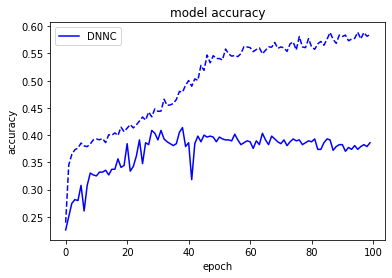

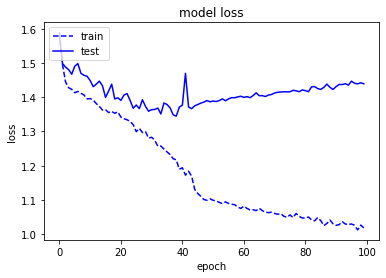

In [10]:
import matplotlib.pylab as plt

acc=np.array(hist['accuracy'])
#acc=acc[0:100]
#acc=np.append(acc,[0.7])
plt.plot(acc,'b--')
plt.plot(hist['val_accuracy'],'b',label='DNNC')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()
# summarize history for loss
loss=np.array(hist['loss'])
#loss=np.append(loss,[2])
plt.plot(loss,'b--',label='train')
plt.plot(hist['val_loss'],'b',label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
from keras.models import load_model
model = load_model('LSTM-ATTENTION-BF-polution.h5')


In [13]:
from sklearn.metrics import classification_report, confusion_matrix


print('Confusion Matrix')
cm=confusion_matrix(np.argmax(y_test,axis=1), np.argmax(model.predict(X_test),axis=1))
print(cm)
scores = model.evaluate(X_test,y_test, verbose=0)
print("Dados Validação %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

pred = model.predict(X_test)
predicted = np.argmax(pred, axis=1)
report = classification_report(np.argmax(y_test, axis=1), predicted,digits=4)
print(report)


Confusion Matrix
[[75 23 12  2  3]
 [33 63 27 13  6]
 [15 43 41 29 12]
 [ 4 22 21 42 19]
 [ 7 11 15 20 17]]
Dados Validação accuracy: 41.39%
              precision    recall  f1-score   support

           0     0.5597    0.6522    0.6024       115
           1     0.3889    0.4437    0.4145       142
           2     0.3534    0.2929    0.3203       140
           3     0.3962    0.3889    0.3925       108
           4     0.2982    0.2429    0.2677        70

    accuracy                         0.4139       575
   macro avg     0.3993    0.4041    0.3995       575
weighted avg     0.4048    0.4139    0.4071       575



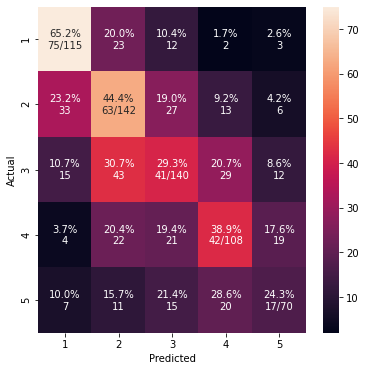

In [14]:
import seaborn as sns

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig("LSTM-polution.pdf")
    plt.show()
    
    
    
cm_analysis(np.argmax(y_test,axis=1),np.argmax(pred,axis=1), labels=["1","2","3","4","5"], ymap=None, figsize=(6,6))